# Student Engagement Metrics Analysis with Open University Learning Analytics Dataset (OULAD)


This notebook demonstrates how to calculate a variety of student engagement metrics using the Open University Learning Analytics Dataset (OULAD). 
We will calculate these metrics step-by-step and use them to predict student pass/fail outcomes.

### Steps Covered:
1. Loading Data
2. Calculating Frequency-Based Engagement Metrics
3. Calculating Timeliness-Based Metrics
4. Calculating Consistency Metrics
5. Calculating Engagement Diversity Metrics
6. Aggregating Engagement Metrics for Model Training



## Step 1: Load the Dataset

First, we load the relevant tables from the OULAD dataset, which includes information about students, their interactions with resources, and assignment data.


In [1]:

import pandas as pd

# Load the relevant CSV files from OULAD dataset
student_info = pd.read_csv('studentInfo.csv')            # Demographics and final result
student_vle = pd.read_csv('studentVle.csv')              # Interactions with learning resources
student_assessment = pd.read_csv('studentAssessment.csv')  # Assessment scores and submission dates
assessments = pd.read_csv('assessments.csv')             # Assessment details (dates and weights)

# View the first few rows of each dataset to understand their structure
print("Student Info:")
print(student_info.head())

print("\nStudent VLE:")
print(student_vle.head())

print("\nStudent Assessment:")
print(student_assessment.head())

print("\nAssessments:")
print(assessments.head())


Student Info:
  code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   
3         AAA             2013J       31604      F     South East Region   
4         AAA             2013J       32885      F  West Midlands Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   
3  A Level or Equivalent   50-60%    35-55                     0   
4     Lower Than A Level   50-60%     0-35                     0   

   studied_credits disability final_result  
0              240          N         Pass  
1               60          N 


## Step 2: Frequency-Based Engagement Metrics

These metrics include login frequency, resource access frequency, total clicks, and approximated time spent on the platform.


In [2]:
print(student_vle.columns)


Index(['code_module', 'code_presentation', 'id_student', 'id_site', 'date',
       'sum_click'],
      dtype='object')


In [3]:

# Weekly Login Frequency
student_vle['week'] = student_vle['date'] // 7
login_frequency = student_vle.groupby(['id_student', 'week']).size().reset_index(name='login_count')
print("Weekly Login Frequency:")
print(login_frequency.head())

# Resource Access Frequency
resource_access_frequency = student_vle.groupby('id_student')['id_site'].count().reset_index(name='resource_access_count')
print("Resource Access Frequency:")
print(resource_access_frequency.head())

# Total Clicks per Student
total_clicks = student_vle.groupby('id_student')['sum_click'].sum().reset_index(name='total_clicks')
print("Total Clicks per Student:")
print(total_clicks.head())


Weekly Login Frequency:
   id_student  week  login_count
0        6516    -4           13
1        6516    -3           16
2        6516    -2            2
3        6516    -1           22
4        6516     0           36
Resource Access Frequency:
   id_student  resource_access_count
0        6516                    662
1        8462                    304
2       11391                    196
3       23629                     59
4       23698                    305
Total Clicks per Student:
   id_student  total_clicks
0        6516          2791
1        8462           656
2       11391           934
3       23629           161
4       23698           910



## Step 3: Timeliness-Based Metrics

Calculate assignment submission timeliness by comparing submission dates with due dates.


In [4]:

# Merge `studentAssessment` with `assessments` to get the assignment due date
student_assessment = student_assessment.merge(assessments[['id_assessment', 'date']], on='id_assessment', how='left')

# Calculate timeliness as days early (negative) or late (positive)
student_assessment['timeliness'] = student_assessment['date_submitted'] - student_assessment['date']
print("Assignment Submission Timeliness:")
print(student_assessment[['id_student', 'id_assessment', 'timeliness']].head())


Assignment Submission Timeliness:
   id_student  id_assessment  timeliness
0       11391           1752        -1.0
1       28400           1752         3.0
2       31604           1752        -2.0
3       32885           1752         7.0
4       38053           1752         0.0



## Step 4: Consistency Metrics

Calculate engagement consistency, measuring standard deviation of weekly interactions and counting inactive weeks.


In [5]:

# Calculate weekly clicks for each student
weekly_clicks = student_vle.groupby(['id_student', 'week'])['sum_click'].sum().reset_index()

# Engagement Consistency: Standard deviation of weekly clicks per student
engagement_consistency = weekly_clicks.groupby('id_student')['sum_click'].std().reset_index(name='clicks_std_dev')
print("Engagement Consistency (Standard Deviation of Weekly sum_click):")
print(engagement_consistency.head())

# Days of Inactivity: Count weeks with zero clicks
inactive_weeks = weekly_clicks.groupby('id_student')['sum_click'].apply(lambda x: (x == 0).sum()).reset_index(name='inactive_weeks')
print("Inactive Weeks per Student:")
print(inactive_weeks.head())


Engagement Consistency (Standard Deviation of Weekly sum_click):
   id_student  clicks_std_dev
0        6516       52.764020
1        8462       41.420193
2       11391       40.992738
3       23629       11.404146
4       23698       41.541281
Inactive Weeks per Student:
   id_student  inactive_weeks
0        6516               0
1        8462               0
2       11391               0
3       23629               0
4       23698               0



## Step 5: Engagement Diversity Metrics

Measure the diversity of resources accessed by each student by counting unique resource IDs.


In [6]:

# Count unique resources accessed by each student
resource_diversity = student_vle.groupby('id_student')['id_site'].nunique().reset_index(name='unique_resources')
print("Resource Diversity (Unique Resources Accessed):")
print(resource_diversity.head())


Resource Diversity (Unique Resources Accessed):
   id_student  unique_resources
0        6516                84
1        8462               128
2       11391                55
3       23629                11
4       23698                49



## Step 6: Completion-Based Metrics

Calculate the completion rate of resources and assignments by dividing the number of completed items by total available items.


In [7]:

# Resource Completion Rate
total_resources = student_vle['id_site'].nunique()
student_completions = student_vle.groupby('id_student')['id_site'].nunique().reset_index(name='resources_accessed')
student_completions['completion_rate'] = student_completions['resources_accessed'] / total_resources
print("Resource Completion Rate:")
print(student_completions.head())

# Assignment Completion Rate
assignment_completion_rate = student_assessment.groupby('id_student')['id_assessment'].nunique().reset_index(name='assignments_completed')
print("Assignment Completion Rate:")
print(assignment_completion_rate.head())


Resource Completion Rate:
   id_student  resources_accessed  completion_rate
0        6516                  84         0.013401
1        8462                 128         0.020421
2       11391                  55         0.008775
3       23629                  11         0.001755
4       23698                  49         0.007817
Assignment Completion Rate:
   id_student  assignments_completed
0        6516                      5
1        8462                      7
2       11391                      5
3       23629                      4
4       23698                      9



## Aggregating Metrics and Preparing for Model Training

After calculating each engagement metric, we merge them by `id_student` to create a comprehensive engagement dataset.


In [8]:

# Merge all metrics on `id_student`
engagement_metrics = student_info[['id_student', 'final_result']].copy()
engagement_metrics = engagement_metrics.merge(login_frequency, on='id_student', how='left')
engagement_metrics = engagement_metrics.merge(resource_access_frequency, on='id_student', how='left')
engagement_metrics = engagement_metrics.merge(total_clicks, on='id_student', how='left')
engagement_metrics = engagement_metrics.merge(engagement_consistency, on='id_student', how='left')
engagement_metrics = engagement_metrics.merge(inactive_weeks, on='id_student', how='left')
engagement_metrics = engagement_metrics.merge(resource_diversity, on='id_student', how='left')
engagement_metrics = engagement_metrics.merge(student_completions[['id_student', 'completion_rate']], on='id_student', how='left')
engagement_metrics = engagement_metrics.merge(assignment_completion_rate, on='id_student', how='left')

# Fill any missing values with 0
engagement_metrics.fillna(0, inplace=True)

print("Aggregated Engagement Metrics:")
print(engagement_metrics.head())
import pandas as pd

# Assuming your DataFrame is called 'X'
#X.to_csv("final_data.csv", index=False)



Aggregated Engagement Metrics:
   id_student final_result  week  login_count  resource_access_count  \
0       11391         Pass  -1.0         11.0                  196.0   
1       11391         Pass   0.0         30.0                  196.0   
2       11391         Pass   1.0          4.0                  196.0   
3       11391         Pass   2.0         15.0                  196.0   
4       11391         Pass   4.0          8.0                  196.0   

   total_clicks  clicks_std_dev  inactive_weeks  unique_resources  \
0         934.0       40.992738             0.0              55.0   
1         934.0       40.992738             0.0              55.0   
2         934.0       40.992738             0.0              55.0   
3         934.0       40.992738             0.0              55.0   
4         934.0       40.992738             0.0              55.0   

   completion_rate  assignments_completed  
0         0.008775                    5.0  
1         0.008775               

## Step 1: Define the Target Variable
Convert the final_result column in engagement_metrics to a binary target for pass/fail:
For example, 1 for "Pass" and 0 for "Fail" (or any other outcomes considered as fail).

In [9]:
# Define binary target variable for pass/fail
engagement_metrics['target'] = engagement_metrics['final_result'].apply(lambda x: 1 if x == 'Pass' else 0)


## Step 2: Split Data into Training and Test Sets
Splitting the data into training and testing sets helps to evaluate how well the model generalizes to unseen data.

In [10]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = engagement_metrics.drop(columns=['id_student', 'final_result', 'target'])
y = engagement_metrics['target']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Step 3: Train a Classification Model
Use a simple model, such as Logistic Regression or Random Forest, to start. Here, we’ll use a Random Forest model to handle potentially complex relationships between engagement metrics.

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

## Step 4: Make Predictions and Evaluate the Model
Evaluate the model using metrics like accuracy, precision, recall, and F1-score. These metrics will help you assess the model’s performance in predicting pass/fail outcomes based on engagement metrics.

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Model Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Model Performance:
Accuracy: 0.89
Precision: 0.90
Recall: 0.90
F1 Score: 0.90

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88     62325
           1       0.90      0.90      0.90     74423

    accuracy                           0.89    136748
   macro avg       0.89      0.89      0.89    136748
weighted avg       0.89      0.89      0.89    136748



## Step 5: Analyze Feature Importance (Optional)
Using feature importance, you can determine which engagement metrics are the most influential in predicting student outcomes.

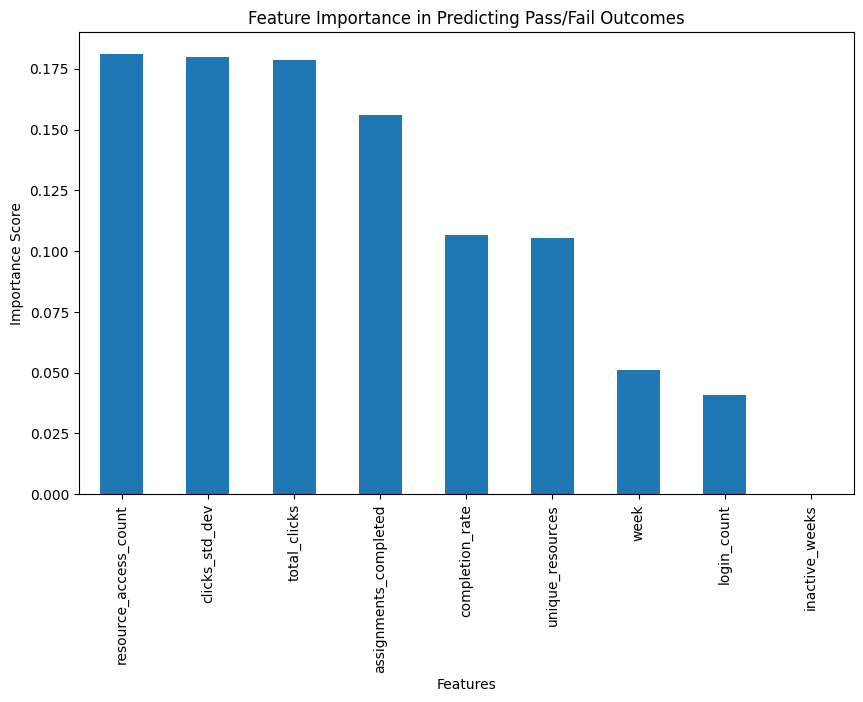

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance from the model
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title("Feature Importance in Predicting Pass/Fail Outcomes")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.show()


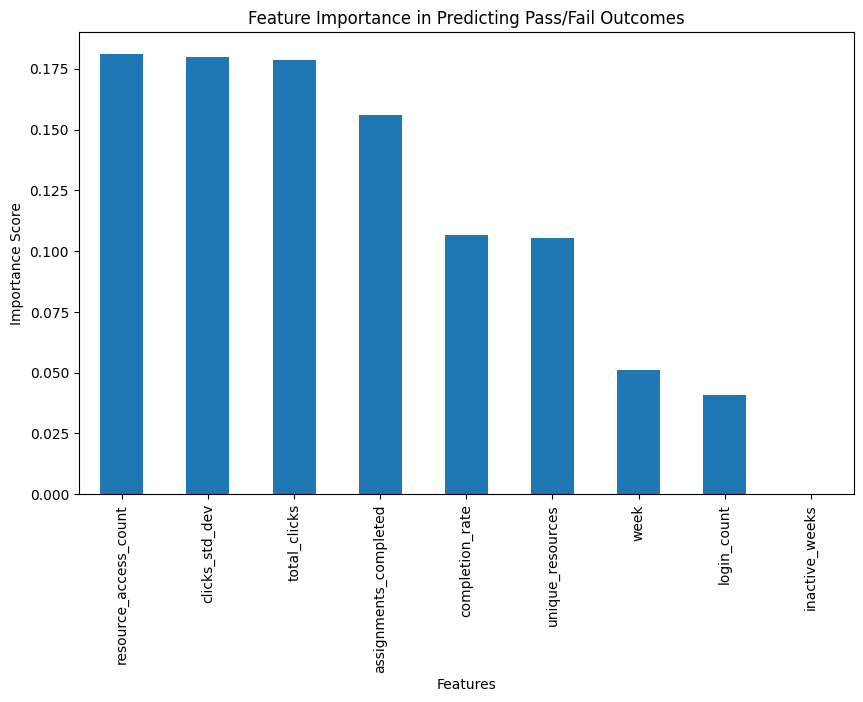

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier

# Initialize and fit the model if not done previously
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title("Feature Importance in Predicting Pass/Fail Outcomes")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.show()


## 1. Random Forest Classifier

Random Forest is an ensemble algorithm that builds multiple decision trees and combines them for improved accuracy and reduced overfitting.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Assuming `X` and `y` are the feature matrix and target vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8943311785181501
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     62325
           1       0.90      0.90      0.90     74423

    accuracy                           0.89    136748
   macro avg       0.89      0.89      0.89    136748
weighted avg       0.89      0.89      0.89    136748



## 2. Logistic Regression

Logistic Regression is a linear model for binary classification that predicts the probability of a target variable belonging to a particular class.


In [16]:
from sklearn.linear_model import LogisticRegression

# Initialize and train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.6340275543335185
              precision    recall  f1-score   support

           0       0.63      0.49      0.55     62325
           1       0.64      0.76      0.69     74423

    accuracy                           0.63    136748
   macro avg       0.63      0.62      0.62    136748
weighted avg       0.63      0.63      0.63    136748



## 3. K-Means Clustering

K-Means is an unsupervised clustering algorithm that groups data points into a specified number of clusters based on similarity.


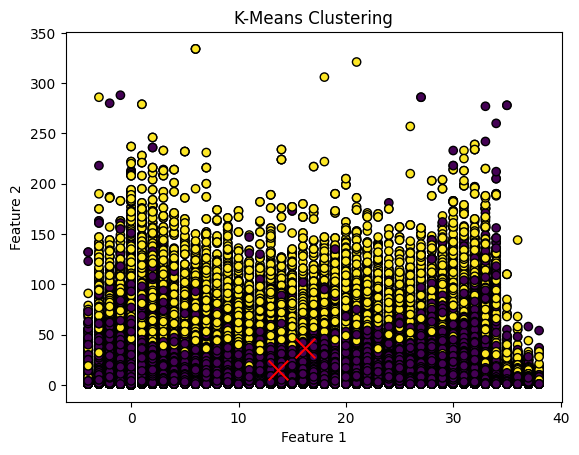

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Initialize and fit K-Means
kmeans = KMeans(n_clusters=2, random_state=50)
kmeans.fit(X)
# Convert X to a NumPy array for indexing with [:, 0] syntax
X_np = X.values  # Convert DataFrame to a NumPy array

# Plotting the Clusters
plt.scatter(X_np[:, 0], X_np[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', edgecolor='k')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='x')
plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()



## 4. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN is a density-based clustering algorithm that groups points in high-density areas and identifies noise points.


## 5. Q-Learning

Q-Learning is a reinforcement learning algorithm that trains an agent to learn the optimal policy by maximizing cumulative reward.

In [1]:

import numpy as np

# Initialize parameters
state_space = 5  # Example: 5 states
action_space = 3  # Example: 3 actions
Q_table = np.zeros((state_space, action_space))
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.2  # Exploration rate

# Define a function to choose an action (epsilon-greedy policy)
def choose_action(state):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(action_space)  # Explore
    else:
        return np.argmax(Q_table[state, :])  # Exploit

# Training Loop
episodes = 1000
for _ in range(episodes):
    state = np.random.randint(0, state_space)  # Random initial state
    done = False
    while not done:
        action = choose_action(state)
        # Take action and observe reward and next state (example values)
        next_state = (state + action) % state_space
        reward = np.random.randn()  # Random reward
        done = np.random.rand() > 0.95  # Random termination condition
        
        # Update Q-value
        Q_table[state, action] = Q_table[state, action] + alpha * (reward + gamma * np.max(Q_table[next_state, :]) - Q_table[state, action])
        state = next_state  # Move to the next state

print("Trained Q-Table:")
print(Q_table)

Trained Q-Table:
[[0.35638173 0.96185888 0.42983141]
 [0.72957976 0.67258659 1.00754153]
 [0.16842069 0.93667677 0.58352352]
 [0.67705196 1.05894444 0.39660996]
 [0.8660188  1.16022209 0.82453993]]


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load Data
file_path = 'final_data.csv'  # Update the path if necessary
data = pd.read_csv(file_path)

# Preprocess Data - Separate target variable and scale only the features
target_col = 'target'  # Change to your actual target column name
if target_col in data.columns:
    y = data[target_col]
    X = data.drop(columns=[target_col])
else:
    X = data.copy()  # For unsupervised algorithms, we'll use the entire dataset without a target variable

# Scale only the feature columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled)


[[-1.36870777 -0.40640716 -0.82511404 ... -0.72271605 -0.72271605
  -0.86175569]
 [-1.27836341  0.55607648 -0.82511404 ... -0.72271605 -0.72271605
  -0.86175569]
 [-1.18801906 -0.76100639 -0.82511404 ... -0.72271605 -0.72271605
  -0.86175569]
 ...
 [ 1.16093421 -0.9129775  -0.85436414 ... -1.05282422 -1.05282422
  -0.41706875]
 [ 1.34162292 -0.30509309 -0.85436414 ... -1.05282422 -1.05282422
  -0.41706875]
 [ 1.52231163 -0.81166343 -0.85436414 ... -1.05282422 -1.05282422
  -0.41706875]]


In [ ]:

from sklearn.model_selection import train_test_split

# Ensure the target column name is correct; update 'target' to your actual target column if different
target_col = 'target'  # Replace 'target' with the correct name if needed

if target_col in data.columns:
    y = data[target_col]
    X = data.drop(columns=[target_col])

    # Proceed with train-test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    print("Train and test split successful.")
else:
    print(f"The target column '{target_col}' does not exist in the dataset. Please check the column name.")


In [7]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Model evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


NameError: name 'X_train' is not defined

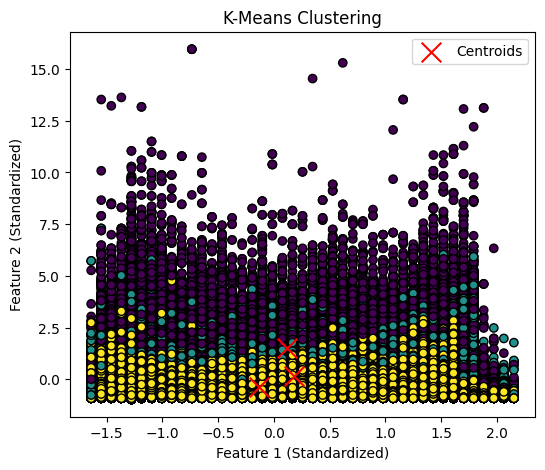

In [6]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

# Visualize K-Means Clustering (using first two features)
plt.figure(figsize=(6, 5))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=data['kmeans_cluster'], cmap='viridis', marker='o', edgecolor='k')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='x', label='Centroids')
plt.title("K-Means Clustering")
plt.xlabel("Feature 1 (Standardized)")
plt.ylabel("Feature 2 (Standardized)")
plt.legend()
plt.show()


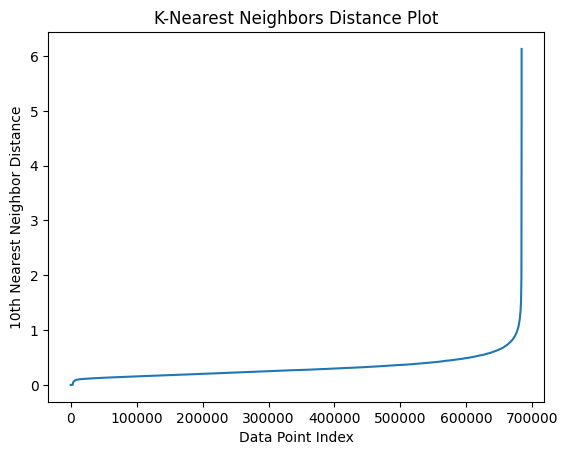

In [5]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=10)  # Set to min_samples - 1
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances to observe the "knee" point
distances = np.sort(distances[:, 9])  # Sort distances to the 10th nearest neighbor
plt.plot(distances)
plt.xlabel("Data Point Index")
plt.ylabel("10th Nearest Neighbor Distance")
plt.title("K-Nearest Neighbors Distance Plot")
plt.show()


In [3]:
import numpy as np

# Q-Learning Setup - Example with 5 states and 3 actions
state_space = 5
action_space = 3
Q_table = np.zeros((state_space, action_space))
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.2  # Exploration rate

# Define action selection function (epsilon-greedy)
def choose_action(state):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(action_space)
    else:
        return np.argmax(Q_table[state, :])

# Training loop for Q-Learning
episodes = 1000
for _ in range(episodes):
    state = np.random.randint(0, state_space)  # Initial state
    done = False
    while not done:
        action = choose_action(state)
        next_state = (state + action) % state_space  # Example transition
        reward = np.random.randn()  # Random reward
        done = np.random.rand() > 0.95  # Random termination
        
        # Q-value update
        Q_table[state, action] = Q_table[state, action] + alpha * (reward + gamma * np.max(Q_table[next_state, :]) - Q_table[state, action])
        state = next_state

# Display Q-table
print("Trained Q-Table:")
print(Q_table)


Trained Q-Table:
[[0.3545476  0.29589045 0.72673495]
 [0.31349062 0.17999752 0.41524984]
 [0.01073639 0.4144719  0.43650711]
 [0.07828439 0.40480608 0.53873084]
 [0.41151134 0.33225052 0.32241036]]


In [4]:
import numpy as np

# Q-Learning Setup - Example with 5 states and 3 actions
state_space = 5
action_space = 3
Q_table = np.zeros((state_space, action_space))
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.2  # Exploration rate

# Define action selection function (epsilon-greedy)
def choose_action(state):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(action_space)
    else:
        return np.argmax(Q_table[state, :])

# Training loop for Q-Learning
episodes = 1000
for _ in range(episodes):
    state = np.random.randint(0, state_space)  # Initial state
    done = False
    while not done:
        action = choose_action(state)
        next_state = (state + action) % state_space  # Example transition
        reward = np.random.randn()  # Random reward
        done = np.random.rand() > 0.95  # Random termination
        
        # Q-value update
        Q_table[state, action] = Q_table[state, action] + alpha * (reward + gamma * np.max(Q_table[next_state, :]) - Q_table[state, action])
        state = next_state

# Display Q-table
print("Trained Q-Table:")
print(Q_table)


Trained Q-Table:
[[-0.00533332 -0.11981833  1.13196129]
 [-0.30497736 -0.29743523 -0.18313759]
 [ 1.71968093  0.02063333  0.04156125]
 [-0.11811983 -0.02049824  0.57747879]
 [-0.63189384 -0.29808573 -0.19407214]]
